In [ ]:
import gym
from gym import spaces
import matplotlib.pyplot as plt
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import cv2
from collections import deque
from IPython.display import clear_output
from gym.spaces.box import Box

In [ ]:
# Cuda device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:

def create_atari_env(env_id):
    env = gym.make(env_id)
    env = AtariRescale84x84(env)
    env = NormalizedEnv(env)
    env = EpisodicLifeEnv(env)
    env = MaxAndSkipEnv(env)
    return env




def process_frame84(frame):
    frame = frame[34:34 + 160, :160]
    frame = cv2.resize(frame, (84, 84))
    frame = frame.mean(2)
    frame = frame.astype(np.float32)
    frame *= (1.0 / 255.0)
    return frame



class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env=None):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        super(EpisodicLifeEnv, self).__init__(env)
        self.lives = 0
        self.was_real_done = True
        self.was_real_reset = False

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert somtimes we stay in lives == 0 condtion for a few frames
            # so its important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset()
            self.was_real_reset = True
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
            self.was_real_reset = False
        self.lives = self.env.unwrapped.ale.lives()
        return obs


class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env=None, skip=4):
        """Return only every `skip`-th frame"""
        super(MaxAndSkipEnv, self).__init__(env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = deque(maxlen=2)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        done = None
        for _ in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            self._obs_buffer.append(obs)
            total_reward += reward
            if done:
                break

        max_frame = np.max(np.stack(self._obs_buffer), axis=0)

        return max_frame, total_reward, done, info

    def reset(self):
        """Clear past frame buffer and init. to first obs. from inner env."""
        self._obs_buffer.clear()
        obs = self.env.reset()
        self._obs_buffer.append(obs)
        return obs
  

class AtariRescale84x84(gym.ObservationWrapper):

    def __init__(self, env=None):
        super(AtariRescale84x84, self).__init__(env)
        self.observation_space = Box(0.0, 1.0, [1, 84, 84])

    def observation(self, observation):
        return process_frame84(observation) 




class NormalizedEnv(gym.ObservationWrapper):

    def __init__(self, env=None):
        super(NormalizedEnv, self).__init__(env)
        self.state_mean = 0
        self.state_std = 0
        self.alpha = 0.9999
        self.num_steps = 0

    def observation(self, observation):
        self.num_steps += 1
        self.state_mean = self.state_mean * self.alpha + \
            observation.mean() * (1 - self.alpha)
        self.state_std = self.state_std * self.alpha + \
            observation.std() * (1 - self.alpha)

        unbiased_mean = self.state_mean / (1 - pow(self.alpha, self.num_steps))
        unbiased_std = self.state_std / (1 - pow(self.alpha, self.num_steps))
        ret = (observation - unbiased_mean) / (unbiased_std + 1e-8)
        return np.expand_dims(ret, axis=0)


class NormalizedState:

    def __init__(self):
        self.state_mean = 0
        self.state_std = 0
        self.alpha = 0.9999
        self.num_steps = 0

    def observation(self, observation):
        self.num_steps += 1
        self.state_mean = self.state_mean * self.alpha + \
            observation.mean() * (1 - self.alpha)
        self.state_std = self.state_std * self.alpha + \
            observation.std() * (1 - self.alpha)

        unbiased_mean = self.state_mean / (1 - pow(self.alpha, self.num_steps))
        unbiased_std = self.state_std / (1 - pow(self.alpha, self.num_steps))
        ret = (observation - unbiased_mean) / (unbiased_std + 1e-8)
        return np.expand_dims(ret, axis=0)

In [ ]:
env_id = 'PongNoFrameskip-v4'
env = create_atari_env(env_id)
num_actions = env.action_space.n

In [ ]:
class DqnCNN(nn.Module):

  def __init__(self, input_space, num_actions):
    '''
    Architecture will be described in the paper, where
    The input to the neural network consits of 84 * 84 * 4 image
    The first hidden layer convolves 16 8x8 filters with stride 4
    The second hidden layer convolves 32 4x4 filters with stride 2
    The final hidden layer is fully connected and consists of 256 units
    '''
    super(DqnCNN, self).__init__()
    self.num_actions = num_actions
    self.conv_layers = nn.Sequential(
        nn.Conv2d(4, 16, 8, 4),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.Conv2d(16, 32, 4, 2),
        nn.BatchNorm2d(32),
        nn.ReLU()
    )
    # Output of conv layers will be size of 2592 (32 * 9 * 9)
    self.fc_layers = nn.Sequential(
        nn.Linear(2592, 256),
        nn.ReLU(),
        nn.Linear(256, num_actions)
    )

  def forward(self, x):
      # Convert input to an tensor with size (n, 4, 84, 84)
      x = torch.FloatTensor(x).view(-1, 4, 84, 84).to(device)
      x = self.conv_layers(x)
      x = self.fc_layers(x.view(-1, 2592))
      return x
  
  def act(self, x, eps):
    if random.random() > eps:
      q_values = self.forward(x)
      action = q_values.max(1)[1]
    else:
      action = random.randint(0, 5)
    return int(action)

In [ ]:
class ReplayBuffer:

  def __init__(self, max_size):
    self.storage = []
    self.max_size = max_size
    self.next_idx = 0
  
  def push(self, state, action, reward, next_state, done):
    data = (state, action, reward, next_state, done)
    if self.max_size > len(self.storage):
      self.storage.append(data)
    else:
      self.storage[self.next_idx % self.max_size] = data
    self.next_idx += 1
  
  def __len__(self):
    return len(self.storage)
  def sample(self, batch_size):
    indexs = [random.randrange(self.__len__()) for _ in range(batch_size)]
    states, actions, rewards, next_states, dones = [], [], [], [], []
    for i in indexs:
      state, action, reward, next_state, done = self.storage[i]
      states.append(state)
      actions.append(action)
      rewards.append(reward)
      next_states.append(next_state)
      dones.append(done)
    return states, actions, rewards, next_states, dones

In [ ]:
def gradient_descent(replay_buffer, model, optimizer, batch_size):
  states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
  states      = torch.FloatTensor(np.float32(states))
  next_states = torch.FloatTensor(np.float32(next_states))
  rewards = torch.FloatTensor(rewards).to(device)
  dones = torch.FloatTensor(dones).to(device)
  actions     = torch.LongTensor(actions).to(device)
  q_values = model(states)
  # q_values for the selected actions
  q_values          = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)
  next_q_values = model(next_states).data
  y = rewards + gamma * next_q_values.max(1)[0] * (1 - done)
  loss = (y - q_values).pow(2).mean()

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  return loss


In [ ]:
model = DqnCNN(env.observation_space.shape, env.action_space.n).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
replay_buffer_size = 10000
replay_buffer = ReplayBuffer(replay_buffer_size)

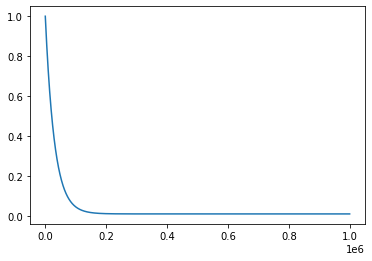

In [ ]:
epsilon_by_frame = lambda frame_idx: 0.2 + (8) * math.exp(-1. * frame_idx / 3000)

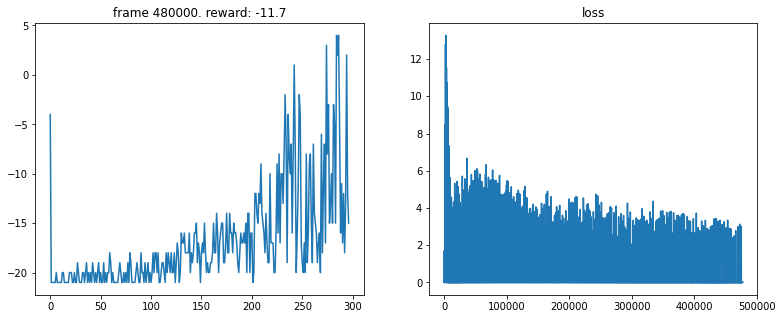

In [ ]:
num_frames = 2000000
batch_size = 32
gamma = 0.99

losses = []
all_rewards = []
episode_reward = 0
state = env.reset()
for frame_idx in range(1, num_frames + 1):
  epsilon = epsilon_by_frame(frame_idx)
  action = model.act(state, epsilon)
  next_state, reward, done, _ = env.step(action)
  replay_buffer.push(state, action, reward, next_state, done)
  state = next_state
  episode_reward += reward
  
  if done:
      state = env.reset()
      all_rewards.append(episode_reward)
      episode_reward = 0

      
  if len(replay_buffer) >= 3000:
      loss = gradient_descent(replay_buffer, model, optimizer, 32)
      losses.append(loss.data)
